✅ Setup complete. Model loaded on cpu.


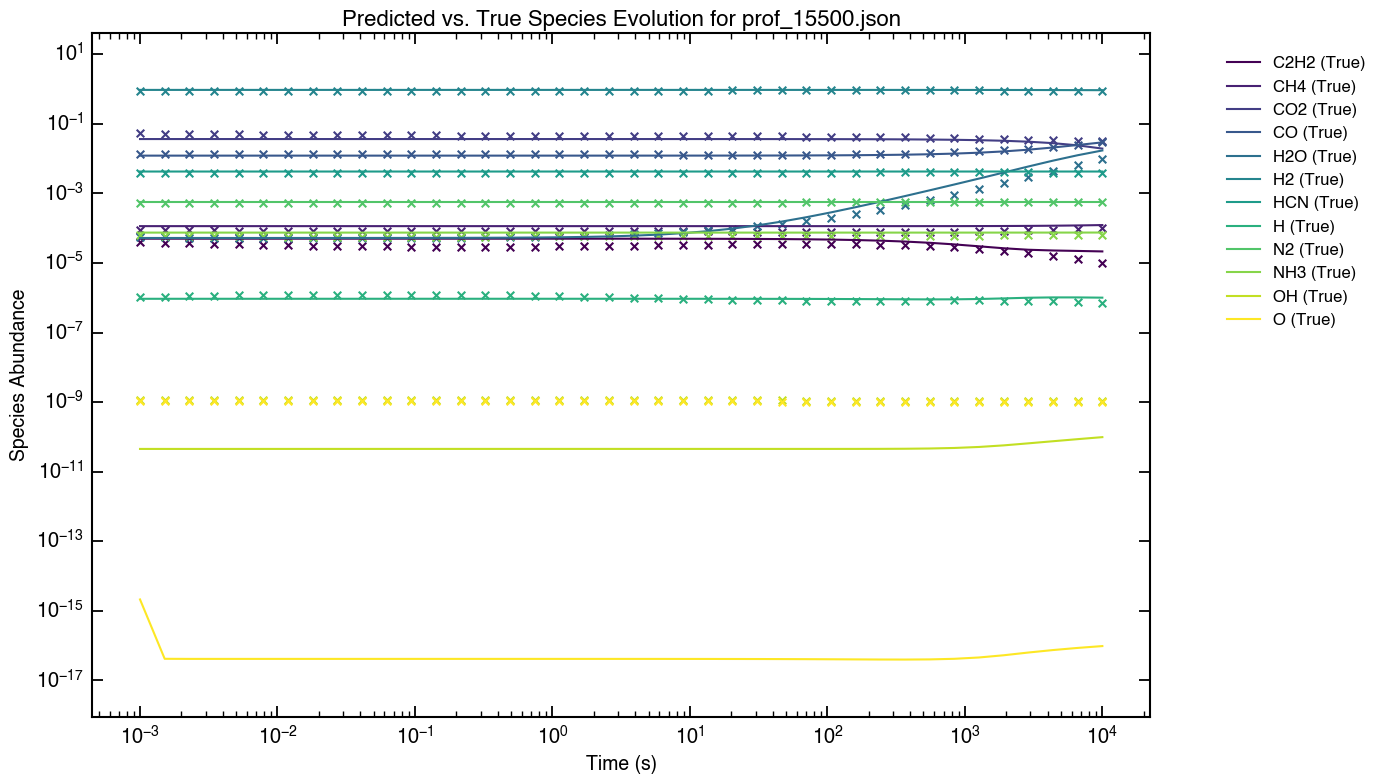

In [3]:
import json
import random
import sys
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

# Add project source to path
project_root = Path.cwd().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
from normalizer import DataNormalizer
from utils import load_config

plt.style.use('science.mplstyle')

# %%
# 2. LOAD ARTIFACTS
# --- Paths ---
CONFIG_FILE = project_root / "inputs/model_input_params.jsonc"
DATA_ROOT = project_root / "data"
config = load_config(CONFIG_FILE)
model_folder = DATA_ROOT / config["output_paths_config"]["fixed_model_foldername"]
normalized_data_folder = DATA_ROOT / config["data_paths_config"]["normalized_profiles_foldername"]
raw_data_folder = DATA_ROOT / config["data_paths_config"]["raw_profiles_foldername"]

# --- Load Model, Metadata, and Test Set list ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(model_folder / "best_model_jit.pt", map_location=device)
model.eval()
with (normalized_data_folder / "normalization_metadata.json").open("r") as f:
    norm_metadata = json.load(f)
with (model_folder / "test_set_info.json").open("r") as f:
    test_filenames = json.load(f)["test_filenames"]

# --- Get variable lists from config ---
species_vars = sorted(config["species_variables"])
global_vars = sorted(config["global_variables"])
species_labels = [s.replace('_evolution', '') for s in species_vars]

print(f"✅ Setup complete. Model loaded on {device}.")

# %%
# 3. PREDICT AND PLOT FOR A SINGLE TEST PROFILE

# --- Select a random test file and load both versions ---
test_filename = random.choice(test_filenames)
with (normalized_data_folder / test_filename).open("r") as f:
    norm_profile = json.load(f)
with (raw_data_folder / test_filename).open("r") as f:
    raw_profile = json.load(f)

# --- Prepare the constant part of the input vector ---
initial_species = [norm_profile[key][0] for key in species_vars]
global_conds = [norm_profile[key] for key in global_vars]
base_input = torch.tensor(initial_species + global_conds, dtype=torch.float32)

# --- Predict for every time step in the profile ---
predicted_evolutions_norm = [] # Store the normalized predictions first
for norm_time_step in norm_profile["t_time"]:
    # Create the full input vector for this time step
    input_vector = torch.cat([base_input, torch.tensor([norm_time_step])]).unsqueeze(0).to(device)
    with torch.no_grad():
        norm_pred = model(input_vector).cpu().squeeze(0)
        predicted_evolutions_norm.append(norm_pred)

# --- Stack and Denormalize All Predictions at Once ---
# 1. Stack the list of 1D tensors into a 2D tensor of shape (num_timesteps, num_species)
predicted_evolutions_norm = torch.stack(predicted_evolutions_norm)

# 2. Transpose it to get shape (num_species, num_timesteps) for easier iteration
predicted_evolutions_norm = predicted_evolutions_norm.T

# 3. Denormalize each species' full time-series vector in one go. This is the fix.
predicted_evolutions_denorm = []
for i, key in enumerate(species_vars):
    # Pass the entire time-series tensor for one species to denormalize
    series_tensor = predicted_evolutions_norm[i]
    denorm_series = DataNormalizer.denormalize(series_tensor, norm_metadata, key)
    predicted_evolutions_denorm.append(denorm_series.numpy()) # Convert to numpy for plotting

# predicted_evolutions_denorm is now a list of numpy arrays, ready for plotting.
raw_times = raw_profile['t_time']

# --- Plot the results ---
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(species_vars)))

for i, key in enumerate(species_vars):
    # Plot true evolution from raw data
    ax.plot(raw_times, raw_profile[key], color=colors[i], label=species_labels[i] + " (True)")
    # Plot predicted evolution (denormalized)
    ax.scatter(raw_times, predicted_evolutions_denorm[i], color=colors[i], marker='x', s=30) # Changed marker for visibility

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Species Abundance", fontsize=14)
ax.set_title(f"Predicted vs. True Species Evolution for {test_filename}", fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()